In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sn

import cv2
from random import randint

import numpy as np

from sklearn.model_selection import train_test_split

from tensorflow.python.client import device_lib

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

In [2]:
CLASSES, gems = [], [] # names of classes, count of images for each class

for root, dirs, files in os.walk('gemstones-images'):
    f = os.path.basename(root)    # get class name - Amethyst, Onyx, etc    
        
    if len(files) > 0:
        gems.append(len(files))
        if f not in CLASSES:
            CLASSES.append(f) # add folder name
    
#     uncomment this block if you want a text output about each subfolder
#     count_dirs = 0
#     for f in dirs:           # count subfolders
#         count_dirs += 1
#     depth = root.split(os.sep)
#     print((len(depth) - 2) * '--'+'>', '{}:\t {} folders, {} imgs'.format(os.path.basename(root), count_dirs, gems[-1] if gems!=[] else 0)) 
    
gems_count = len(CLASSES) # 87 = number of classes
print('{} classes with {} images in total'.format(len(CLASSES), sum(gems)))

# f, ax = plt.subplots(figsize=(15,6))
# if(gems[0])<10:
#     plt.bar(range(gems_count), gems[gems_count:], label = 'Train data')
#     plt.bar(range(gems_count), gems[0:gems_count], label = 'Test data')
# else:
#     plt.bar(range(gems_count), gems[0:gems_count], label = 'Train data')
#     plt.bar(range(gems_count), gems[gems_count:], label = 'Test data')
# ax.grid()
# ax.legend(fontsize = 12);

15 classes with 569 images in total


In [3]:
img_w, img_h = 220, 220    # width and height of image

train_dir = 'gemstones-images/train/'

In [4]:
def read_imgs_lbls(_dir):
    Images, Labels = [], []
    for root, dirs, files in os.walk(_dir):
        f = os.path.basename(root)  # get class name - Amethyst, Onyx, etc   
        print(f)
        for file in files:
            Labels.append(f)
            try:
                image = cv2.imread(root+'/'+file)              # read the image (OpenCV)
                image = cv2.resize(image,(int(img_w*1.5), int(img_h*1.5)))       # resize the image (images are different sizes)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # converts an image from BGR color space to RGB
                Images.append(image)
            except Exception as e:
                print(e)
    Images = np.array(Images)
    return (Images, Labels)

In [5]:
def get_class_index(Labels):
    for i, n in enumerate(Labels):
        for j, k in enumerate(CLASSES):    # foreach CLASSES
            if n == k:
                Labels[i] = j
    Labels = np.array(Labels)
    return Labels

In [6]:
Train_Imgs, Train_Lbls = read_imgs_lbls(train_dir)
Train_Lbls = get_class_index(Train_Lbls)
print()
print()
# print('Shape of train images: {}'.format(Train_Imgs.shape))
# print('Shape of train labels: {}'.format(Train_Lbls.shape))


Alexandrite
Almandine
Amazonite
Amber
Amethyst
Ametrine
Andalusite
Andradite
Aquamarine
Aventurine Green
Aventurine Yellow
Fluorite
Ruby
Sapphire Blue
Zoisite




In [7]:
def edge_and_cut(img):
    try:
        edges = cv2.Canny(img, img_w, img_h)            
        
        if(np.count_nonzero(edges)>edges.size/10000):           
            pts = np.argwhere(edges>0)
            y1,x1 = pts.min(axis=0)
            y2,x2 = pts.max(axis=0)
            
            new_img = img[y1:y2, x1:x2]           # crop the region
            new_img = cv2.resize(new_img,(img_w, img_h))  # Convert back
        else:
            new_img = cv2.resize(img,(img_w, img_h))
    
    except Exception as e:
        print(e)
        new_img = cv2.resize(img,(img_w, img_h))
    
    return new_img

In [8]:
dim = 4 #you can change it;  4x4 dimension flat plot

# f,ax = plt.subplots(dim,dim) 
# f.subplots_adjust(0,0,2,2)
# for i in range(0,dim):
#     for j in range(0,dim):
#         rnd_number = randint(0,len(Train_Imgs))
#         cl = Train_Lbls[rnd_number]
#         ax[i,j].imshow(Train_Imgs[rnd_number])
#         ax[i,j].set_title(CLASSES[cl]+': ' + str(cl))
#         ax[i,j].axis('off')


In [9]:
def crop_images(Imgs):
    CroppedImages = np.ndarray(shape=(len(Imgs), img_w, img_h, 3), dtype=int)

    ind = 0
    for im in Imgs:
        imCon = np.uint8(im)
        x = edge_and_cut(imCon)
        CroppedImages[ind] = x
        ind += 1

    return CroppedImages

In [10]:
def show_cropped(img):
    try:
        emb_img = img.copy()
        edges = cv2.Canny(img, 220, 220)

        if(np.count_nonzero(edges)>edges.size/10000):
            pts = np.argwhere(edges>0)
            y1,x1 = pts.min(axis=0)
            y2,x2 = pts.max(axis=0)

            new_img = img[y1:y2, x1:x2]  

            edge_size = 1 #replace it with bigger size for larger images            

            emb_img[y1-edge_size:y1+edge_size, x1:x2] = [255, 0, 0]
            emb_img[y2-edge_size:y2+edge_size, x1:x2] = [255, 0, 0]
            emb_img[y1:y2, x1-edge_size:x1+edge_size] = [255, 0, 0]
            emb_img[y1:y2, x2-edge_size:x2+edge_size] = [255, 0, 0]

            new_img = cv2.resize(new_img,(img_w, img_h))  # Convert to primary size  

        else:
            new_img = cv2.resize(img,(img_w, img_h))

        fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
        ax[0].imshow(img, cmap='gray')
        ax[0].set_title('Original Image', fontsize=14)
        ax[1].imshow(edges, cmap='gray')
        ax[1].set_title('Canny Edges', fontsize=14)
        ax[2].imshow(emb_img, cmap='gray')
        ax[2].set_title('Bounding Box', fontsize=14)       
        ax[3].imshow(new_img, cmap='gray')
        ax[3].set_title('Cropped', fontsize=14)   
    except Exception as e:
        print(e)
        new_img = cv2.resize(img,(img_w, img_h))

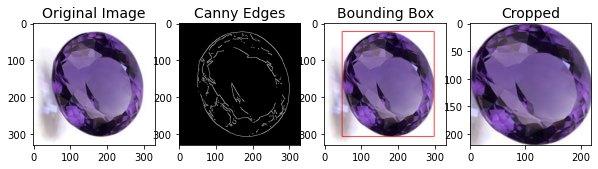

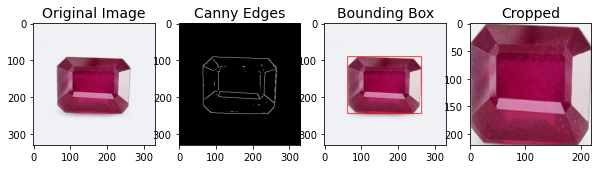

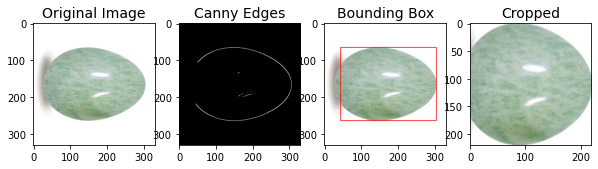

In [11]:
# for x in range(0,3):
#     show_cropped(Train_Imgs[randint(0, len(Train_Imgs))][0])

#### Image cropping and plotting code  #####
# img = cv2.imread("gemstones-images/train//Ruby/ruby_0.jpg")
# edges = cv2.Canny(img, 220, 200)
# plt.subplot(121),plt.imshow(img,cmap = 'gray')
# plt.title('Original Image'), plt.xticks([]), plt.yticks([])
# plt.subplot(122),plt.imshow(edges,cmap = 'gray')
# plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
# plt.show()

# show_cropped(img)
for x in range (0, 3):
    img = np.uint8(Train_Imgs[randint(0, len(Train_Imgs))])
    show_cropped(img)

In [12]:
Train_Imgs = crop_images(Train_Imgs)
print('Final shape of images in train set: {} '.format(Train_Imgs.shape))

Final shape of images in train set: (505, 220, 220, 3) 


In [13]:
X_train, X_val, y_train, y_val = train_test_split(Train_Imgs, Train_Lbls, shuffle = True, test_size = 0.2, random_state = 42)
print('Shape of X_train: {}, y_train: {} '.format(X_train.shape, y_train.shape))
print('Shape of X_val: {}, y_val: {} '.format(X_val.shape, y_val.shape))

Shape of X_train: (404, 220, 220, 3), y_train: (404,) 
Shape of X_val: (101, 220, 220, 3), y_val: (101,) 


In [14]:
devices = device_lib.list_local_devices()
print(devices)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16533001966076330935
]


In [15]:
filters = 32      # the dimensionality of the output space
kernel_size = 3   # length of the 2D convolution window
max_pool = 2      # size of the max pooling windows

In [16]:
EPOCHS = 70                                  # while testing you can change it
batch_size = 32                              # number of training samples using in each mini batch during GD (gradient descent) 
iter_per_epoch = len(X_train) // batch_size  # each sample will be passed [iter_per_epoch] times during training
val_per_epoch = len(X_val) // batch_size     # each sample will be passed [val_per_epoch] times during validation

In [17]:
model = Sequential()

# first layer
model.add(Conv2D(batch_size, (kernel_size, kernel_size), activation='relu', padding='same', input_shape=(img_w, img_h, 3))) # 32
model.add(MaxPooling2D((max_pool, max_pool))) #reduce the spatial size of incoming features

# second layer
model.add(Conv2D(2*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 64
model.add(MaxPooling2D((max_pool, max_pool))) 

# third layer
model.add(Conv2D(4*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 128
model.add(MaxPooling2D((max_pool, max_pool))) 

# fourth layer
model.add(Conv2D(4*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 128
model.add(AveragePooling2D(pool_size= (2, 2), strides= (2, 2))) 

# fifth layer
model.add(Conv2D(4*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 128
model.add(MaxPooling2D((max_pool, max_pool))) 

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(16*batch_size, activation='relu'))                                             # 512
model.add(Dense(87, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 55, 55, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 128)       1

In [18]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [19]:
train_datagen = ImageDataGenerator(              # this is the augmentation configuration used for training
        rotation_range=25,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        horizontal_flip=True
        )

val_datagen = ImageDataGenerator()                # for val/testing only rescaling function 


In [20]:
train_gen = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_gen = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [21]:
m = model.fit(
       train_gen,
       steps_per_epoch= iter_per_epoch,
       epochs=EPOCHS, 
       validation_data = val_gen,
       validation_steps = val_per_epoch,
       verbose = 1 # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
       )

Epoch 1/70
12/12 [==============================] - 35s 3s/step - loss: 9.7617 - accuracy: 0.1237 - val_loss: 2.5434 - val_accuracy: 0.2292
Epoch 2/70
12/12 [==============================] - 34s 3s/step - loss: 1.8802 - accuracy: 0.3522 - val_loss: 1.8744 - val_accuracy: 0.3750
Epoch 3/70
12/12 [==============================] - 37s 3s/step - loss: 1.5268 - accuracy: 0.4624 - val_loss: 1.9792 - val_accuracy: 0.4479
Epoch 4/70
12/12 [==============================] - 39s 3s/step - loss: 1.3054 - accuracy: 0.5323 - val_loss: 1.2830 - val_accuracy: 0.5208
Epoch 5/70
12/12 [==============================] - 39s 3s/step - loss: 1.2405 - accuracy: 0.5753 - val_loss: 1.4780 - val_accuracy: 0.5208
Epoch 6/70
12/12 [==============================] - 40s 3s/step - loss: 1.0203 - accuracy: 0.6586 - val_loss: 1.4458 - val_accuracy: 0.5417
Epoch 7/70
12/12 [==============================] - 39s 3s/step - loss: 1.0441 - accuracy: 0.6156 - val_loss: 1.4861 - val_accuracy: 0.5417
Epoch 8/70
12/12 [==

12/12 [==============================] - 36s 3s/step - loss: 1.1077 - accuracy: 0.6183 - val_loss: 1.1072 - val_accuracy: 0.6562
Epoch 60/70
12/12 [==============================] - 36s 3s/step - loss: 0.7483 - accuracy: 0.7366 - val_loss: 1.2007 - val_accuracy: 0.7396
Epoch 61/70
12/12 [==============================] - 42s 4s/step - loss: 0.4185 - accuracy: 0.8387 - val_loss: 1.0031 - val_accuracy: 0.7292
Epoch 62/70
12/12 [==============================] - 46s 4s/step - loss: 0.4218 - accuracy: 0.8763 - val_loss: 1.0366 - val_accuracy: 0.7604
Epoch 63/70
12/12 [==============================] - 42s 3s/step - loss: 0.3612 - accuracy: 0.8656 - val_loss: 0.8639 - val_accuracy: 0.7708
Epoch 64/70
12/12 [==============================] - 43s 4s/step - loss: 0.3151 - accuracy: 0.9086 - val_loss: 1.0407 - val_accuracy: 0.7396
Epoch 65/70
12/12 [==============================] - 40s 3s/step - loss: 0.9592 - accuracy: 0.7204 - val_loss: 1.3310 - val_accuracy: 0.5521
Epoch 66/70
12/12 [======

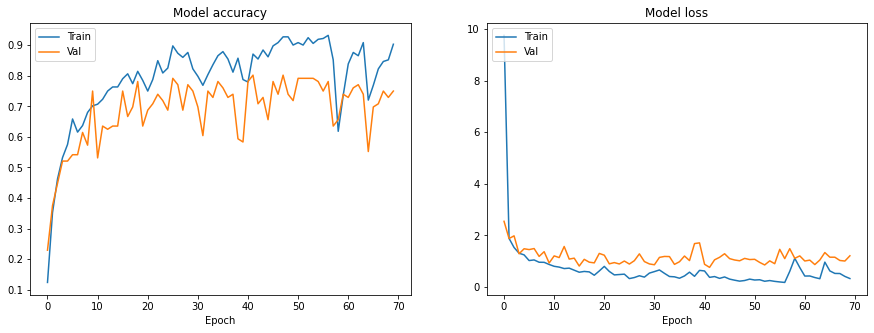

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axs[0].plot(m.history['accuracy'])
axs[0].plot(m.history['val_accuracy'])
axs[0].set_title('Model accuracy')
axs[0].legend(['Train', 'Val'], loc='upper left')

axs[1].plot(m.history['loss'])
axs[1].plot(m.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].legend(['Train', 'Val'], loc='upper left')

for ax in axs.flat:
    ax.set(xlabel='Epoch')


In [23]:
score = model.evaluate_generator(val_gen, steps= len(val_gen))

for idx, metric in enumerate(model.metrics_names):
    print('{}:{}'.format(metric, score[idx]))

Instructions for updating:
Please use Model.evaluate, which supports generators.
loss:1.1566011905670166
accuracy:0.7623762488365173


<AxesSubplot:>

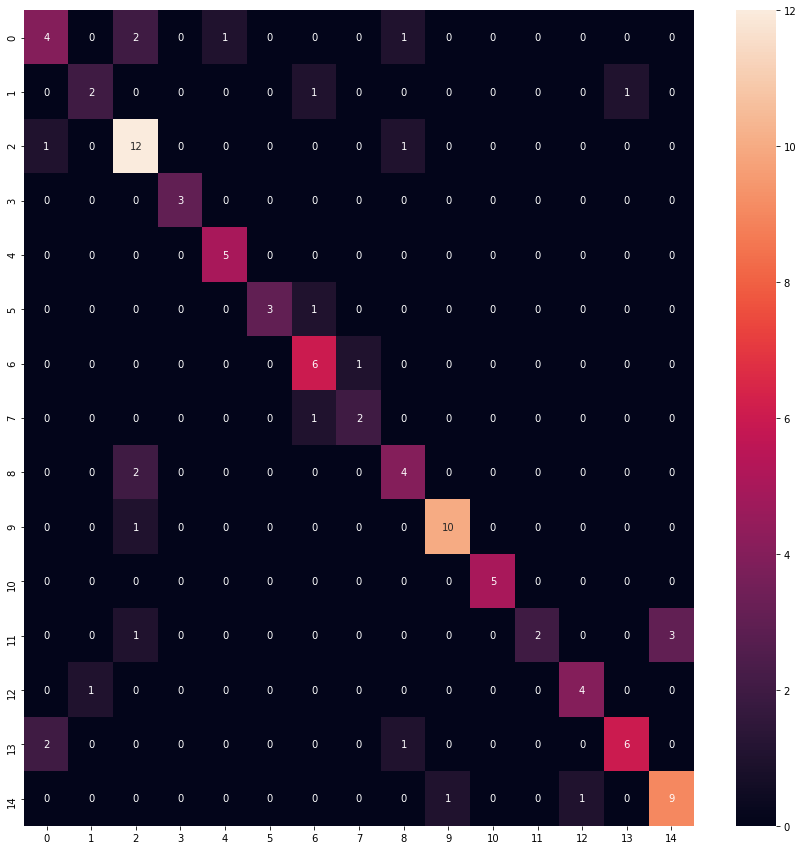

In [24]:
from sklearn.metrics import confusion_matrix
y_pre_test=model.predict(X_val)
y_pre_test=np.argmax(y_pre_test,axis=1)
cm=confusion_matrix(y_val,y_pre_test)

plt.figure(figsize = (15,15))
sn.heatmap(cm, annot=True)

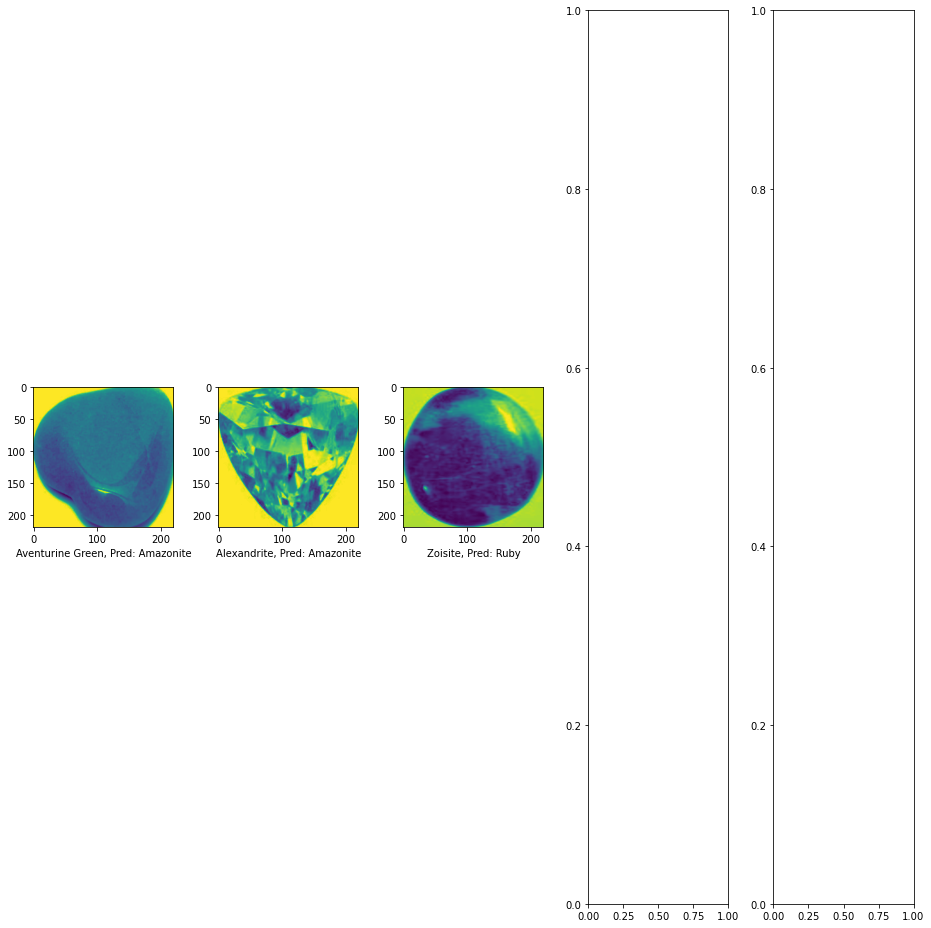

In [25]:
x=(y_pre_test-y_val!=0).tolist()
x=[i for i,l in enumerate(x) if l!=False]

fig,ax=plt.subplots(1,5,sharey=False,figsize=(13,13))
fig.tight_layout()

for i in range(3):
    ax[i].imshow(X_val[x[i]][:,:,1])
    ax[i].set_xlabel('{}, Pred: {}'.format(CLASSES[y_val[x[i]]],CLASSES[y_pre_test[x[i]]]))


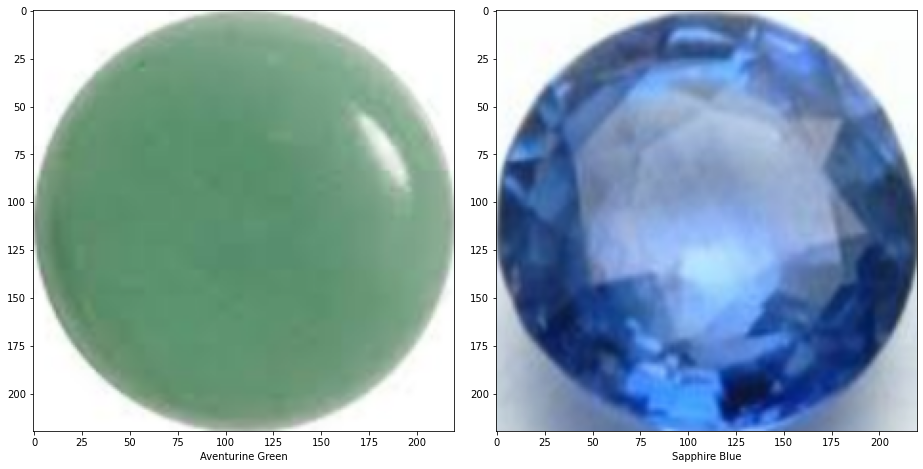

In [26]:
red_stones = ['Aventurine Green','Sapphire Blue']
red_stones = get_class_index(red_stones)

fig,ax=plt.subplots(1,len(red_stones),sharey=False,figsize=(13,13))
fig.tight_layout()

for i in range(len(red_stones)):
    ax[i].imshow(Train_Imgs[np.where(Train_Lbls==red_stones[i])[0][1]])
    ax[i].set_xlabel(CLASSES[red_stones[i]])

In [27]:
model.save('model_gemstones.h5')

In [28]:
test_dir = 'gemstones-images/test/'

In [29]:
Test_Imgs, Test_Lbls = read_imgs_lbls(test_dir)
Test_Lbls = get_class_index(Test_Lbls)


Alexandrite
Almandine
Amazonite
Amber
Amethyst
Ametrine
Andalusite
Andradite
Aquamarine
Aventurine Green
Aventurine Yellow
Fluorite
Ruby
Sapphire Blue
Zoisite


In [30]:
Test_Imgs = crop_images(Test_Imgs)
print('shape of images in test set: {} '.format(Test_Imgs.shape))

shape of images in test set: (64, 220, 220, 3) 


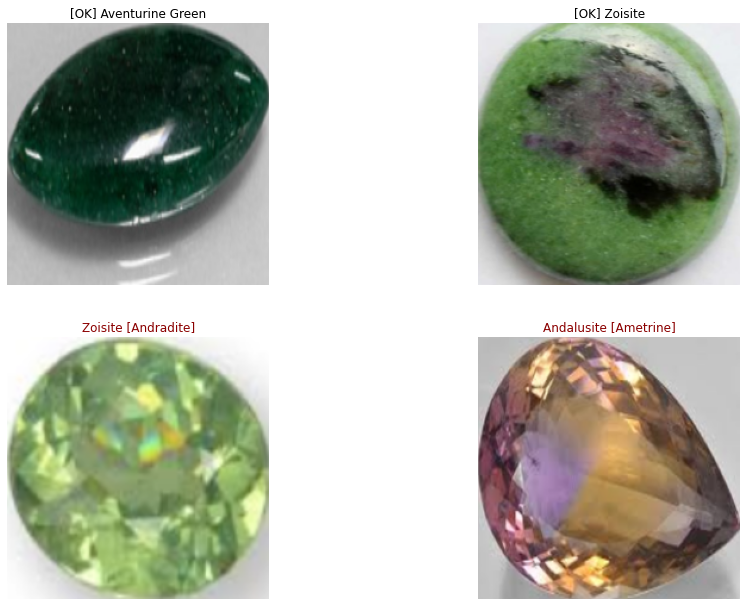

In [33]:
f,ax = plt.subplots(2,2) 
f.subplots_adjust(0,0,2,2)
for i in range(0,2,1):
    for j in range(0,2,1):
        rnd_number = randint(0,len(Test_Imgs))
        pred_image = np.array([Test_Imgs[rnd_number]])
        pred_class = model.predict_classes(pred_image)[0]
        pred_prob = model.predict(pred_image).reshape(87)
        act = CLASSES[Test_Lbls[rnd_number]]
        ax[i,j].imshow(Test_Imgs[rnd_number])
        ax[i,j].imshow(pred_image[0])
        if(CLASSES[pred_class] != CLASSES[Test_Lbls[rnd_number]]):
            t = '{} [{}]'.format(CLASSES[pred_class], CLASSES[Test_Lbls[rnd_number]])
            ax[i,j].set_title(t, fontdict={'color': 'darkred'})
        else:
            t = '[OK] {}'.format(CLASSES[pred_class]) 
            ax[i,j].set_title(t)
        ax[i,j].axis('off')
